## Домашнее задание по NLP №2

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: “теплое пиво” – это плохо, а “теплый свитер” – это хорошо.

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

1
2
3
4
5
6
7
8
9
10
11
Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    тест на определение ближайших слов
    тест на аналогии (мужчина – король : женщина – королева)
    тест на определение лишнего слова.

Постройте несколько визуализаций:
    TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.
Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import json
from tqdm import tqdm
import bz2
from gensim.models import word2vec

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


### Загружаем данные

In [54]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

|          | 0/? [00:00<?, ?it/s]

In [68]:
df = pd.DataFrame.from_dict(responses)
# посмотрим, что там
df.tail()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0
153498,None,False,Быстро и удобно,0,лицензия № 1326,Денис,Альфа-Банк,2005-04-13 17:43:00,"Если коротко, то мне нравится. Кридит получать...",5.0


In [69]:
pymorphy2 = MorphAnalyzer()
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']

In [70]:
# подготовим и преобразуем текст
def preproc_review(review):
    tokens = nltk.sent_tokenize(review)
    list_ = []
    for index in range(len(tokens)):
        text = re.sub('[^А-Яа-яё]', ' ', tokens[index])
        text = text.lower()
        text = nltk.word_tokenize(text)
        text = [word for word in text if word not in mystopwords]
        text = [pymorphy2.parse(word)[0].normal_form for word in text]
        text = ' '.join(text)
        text = nltk.word_tokenize(text)
        list_.append(text)
    return list_

In [71]:
# возьмем первые 50 тыс
df_example = df[['text', 'rating_grade']][:50000]

In [72]:
df_example.head()

,text,rating_grade
0,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [73]:
df_example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          50000 non-null  object 
 1   rating_grade  22578 non-null  float64
dtypes: float64(1), object(1)
memory usage: 781.4+ KB


In [84]:
%%time
df_example['changed'] = df_example.text.apply(preproc_review)

Wall time: 17min 48s


In [85]:
# посмотрим, что получилось
df_example.head()

,text,rating_grade,changed
0,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"[[добрый, день], [являться, клиент, банк, пору..."
1,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"[[добрый, день], [являться, держатель, зарплат..."
2,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"[[здравствуйте], [дублировать, свой, заявление..."
3,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"[[добрый, день], [открыть, расчётный, счёт, сб..."
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"[[г, взять, кредит, ваш, банк, заявить, я, сум..."


### Записываем данные для последующей подачи в обучение модели

In [86]:
sentences = []  

for review in df_example['changed']:
    sentences += review

In [91]:
sentences[:3]

[['добрый', 'день'],
 ['являться',
  'клиент',
  'банк',
  'поручитель',
  'кредитный',
  'договор',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'банк',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность'],
 ['начинать',
  'март',
  'год',
  'начать',
  'приходить',
  'бесконечный',
  'письмо',
  'ооо',
  'прить',
  'коллект',
  'адрес',
  'город',
  'москва',
  'уваровский',
  'переулок',
  'дом',
  'квартира',
  'угроза',
  'возбуждение',
  'уголовный',
  'дело',
  'отношение',
  'гражданин',
  'филиппов',
  'эдуард',
  'владимирович',
  'который',
  'уклоняться',
  'уплата',
  'взять',
  'кредит',
  'договор',
  'год',
  'договор',
  'год']]

### Обучаем модель

In [92]:
%%time
model = word2vec.Word2Vec(sentences, workers=4, vector_size=300, min_count=4, window=8, sample=1e-3)

Wall time: 19.6 s


In [93]:
# размер словаря
print(len(model.wv.index_to_key))

21352


#### Тест на определение ближайших слов 

In [94]:
words = ['банк', 'кредит', 'вклад']
for word in words:
    print(word, '\n', '--------------')
    for word, cos in model.wv.most_similar(positive=[word], topn=3):
        print(word, ': ', cos)
    print('\n')

банк 
 --------------
сбербанк :  0.4127347469329834
росбанк :  0.38799649477005005
промсвязьбанк :  0.3712600767612457


кредит 
 --------------
автокредит :  0.7379372119903564
ипотека :  0.6409664750099182
рассрочка :  0.5797572731971741


вклад 
 --------------
депозит :  0.8957708477973938
чемпион :  0.5693703889846802
капитализация :  0.5503365397453308




#### Тест на аналогии

In [95]:
model.wv.most_similar(positive=['кредит','ипотека'], negative=['вклад'], topn=1)

[('автокредит', 0.7348905205726624)]

#### Тест на определение лишнего слова

In [96]:
model.wv.doesnt_match(['работник', 'сотрудник', 'стажер', 'кредит'])

'кредит'

In [97]:
model.wv.doesnt_match(['кредит', 'ипотека', 'автокредит', 'депозит'])

'депозит'

### Визуализация

In [98]:
X = model.wv[model.wv.index_to_key]

In [99]:
X 

array([[ 1.4144169e-01,  2.3238564e-01,  3.3484355e-01, ...,
         1.6404633e-01, -5.0064009e-01, -4.9901524e-01],
       [-6.8292096e-02, -3.7103939e-01, -5.2675581e-01, ...,
        -3.2640204e-02, -2.3472946e+00, -2.2415998e+00],
       [ 8.8810161e-02, -1.2818475e+00, -1.1370609e+00, ...,
         5.2693933e-01, -6.4838730e-02, -6.1765492e-01],
       ...,
       [ 1.3744374e-02,  1.2372229e-01, -1.6827917e-02, ...,
        -1.8015787e-02,  5.7645004e-02, -4.2501725e-02],
       [-3.7764083e-03,  4.5550469e-02,  1.5792213e-02, ...,
        -6.3807918e-03,  1.7692954e-03, -4.4453364e-02],
       [ 3.5601077e-03, -3.0432297e-02, -2.4513619e-02, ...,
         2.6478933e-02, -2.6333185e-02, -8.0321012e-03]], dtype=float32)

In [100]:
from sklearn.decomposition import PCA

In [101]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

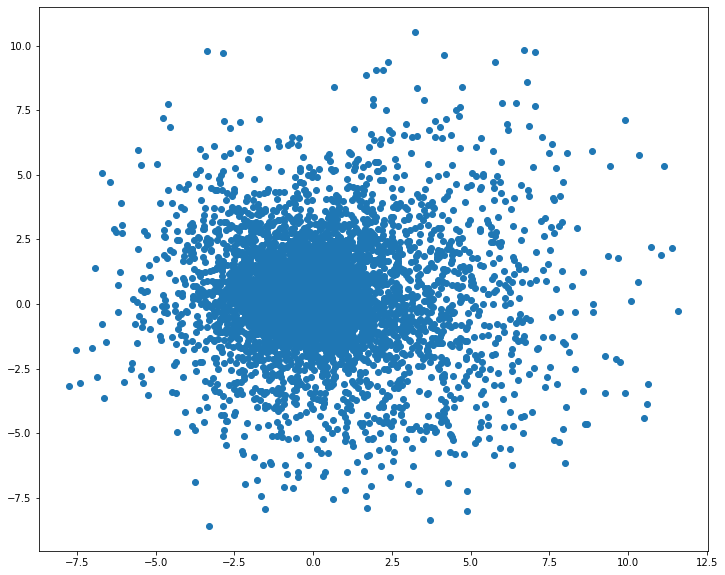

In [102]:
plt.figure(figsize=(12,10))
plt.scatter(result[:, 0], result[:, 1])

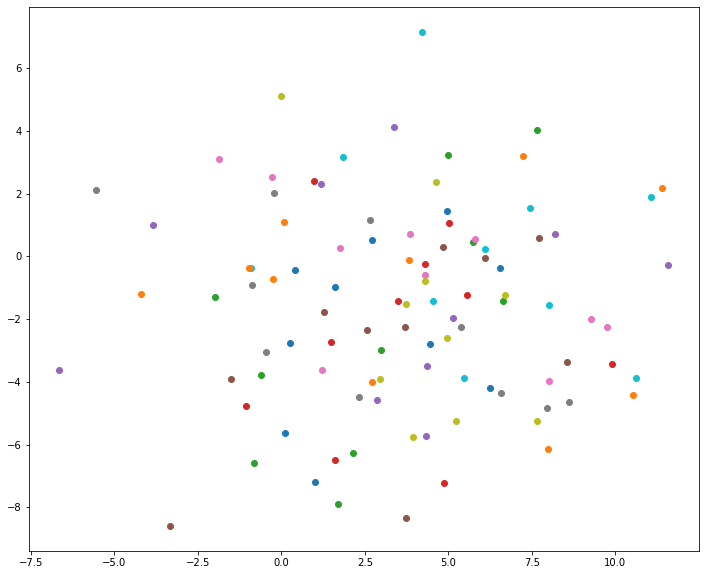

In [103]:
plt.figure(figsize=(12,10))
words = list(model.wv.index_to_key)[:100]
for i, word in enumerate(words):
    plt.scatter(result[i, 0], result[i, 1])

In [104]:
from nltk import FreqDist
from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import TSNE

top_words = []


fd = FreqDist()
for s in tqdm(sentences):
    fd.update(s)

for w in fd.most_common(100):
    top_words.append(w[0])
    
print(top_words[:50:])
top_words_vec = model.wv[top_words]

  0%|          | 0/786466 [00:00<?, ?it/s]

['банк', 'карта', 'мой', 'день', 'деньга', 'кредит', 'который', 'сотрудник', 'клиент', 'счёт', 'отделение', 'сумма', 'сказать', 'год', 'свой', 'заявление', 'вопрос', 'вклад', 'номер', 'ваш', 'время', 'договор', 'мочь', 'платёж', 'кредитный', 'телефон', 'такой', 'получить', 'ответ', 'дать', 'быть', 'звонок', 'г', 'офис', 'средство', 'звонить', 'сбербанк', 'рубль', 'месяц', 'написать', 'проблема', 'какой', 'позвонить', 'ситуация', 'очень', 'прийти', 'работа', 'человек', 'смс', 'информация']


In [105]:
%%time
tsne = TSNE(n_components=2, random_state=77)
top_words_tsne = tsne.fit_transform(top_words_vec)

Wall time: 211 ms


In [106]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (model, top100 words)")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

Text(0.5, 0, 'Скорость')

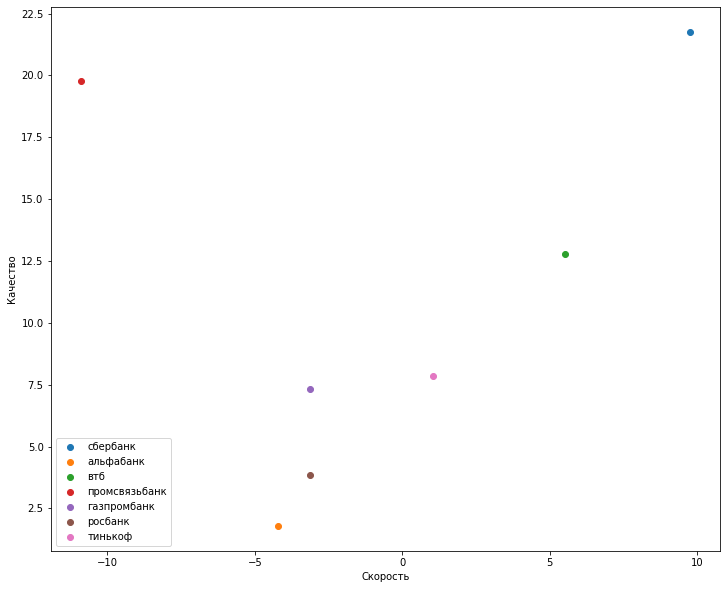

In [107]:
plt.figure(figsize=(12,10))
banks = ['сбербанк', 'альфабанк', 'втб', 'промсвязьбанк', 'газпромбанк', 'росбанк', 'тинькоф']
for bank in banks:
    x = (model.wv['быстро'] - model.wv['медленно']) @ model.wv[bank]
    y = (model.wv['хороший'] - model.wv['плохой']) @ model.wv[bank]
    plt.scatter(x, y, label=bank)
    plt.legend()
plt.ylabel('Качество')
plt.xlabel('Скорость')
